In [2]:
import joblib, json, glob, re, os, itertools, warnings, pickle
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from umap import UMAP
plt.style.use('seaborn-v0_8-paper')
warnings.filterwarnings('ignore')

RESULTS_DIR = "/home/diego/Escritorio/limpio/resultados/28"   # <-- ajusta
SUFFIX_RE = re.compile(r"all_folds_metrics_MULTI_(.+)\.csv")
CSV_PATH  = glob.glob(f"{RESULTS_DIR}/all_folds_metrics_MULTI_*.csv")[0]
SUFFIX    = SUFFIX_RE.search(CSV_PATH).group(1)
HIST_PATH = f"{RESULTS_DIR}/all_folds_vae_training_history_{SUFFIX}.joblib"
PRED_PATH = f"{RESULTS_DIR}/all_folds_clf_predictions_MULTI_{SUFFIX}.joblib"
print("🗂  Using suffix:", SUFFIX)


🗂  Using suffix: xgb_vaeconvtranspose4l_ld256_beta1.1_normzscore_offdiag_ch4sel_intFChalf_drop0.25_ln1_outer5x1_scoreauc_bal07


In [4]:
import pandas as pd

# 1) Lee tus métricas y quita las columnas que no necesitas
metrics = pd.read_csv(CSV_PATH)
df = metrics.drop(columns=['fold','best_params'])

# 2) Agrupa por clasificador y calcula mean y std
grouped = df.groupby('classifier').agg(['mean','std']).round(3)

# 3) Separa mean y std en dos DataFrames “anchos”
means = grouped.xs('mean', axis=1, level=1)
stds  = grouped.xs('std',  axis=1, level=1)

# 4) Junta en un único DataFrame con “mean ± std”
table1 = means.astype(str) + ' ± ' + stds.astype(str)
table1.index.name = 'Metric'

# 5) Muestra o exporta a LaTeX
display(table1)
# si quieres exportar a LaTeX:
# print(table1.to_latex())
           # ➜ cópialo a LaTeX con `.to_latex()`



,auc,pr_auc,optimal_threshold,acc_def,bal_acc_def,sens_def,spec_def,f1_def,acc_opt,bal_acc_opt,sens_opt,spec_opt,f1_opt,auc_bal07
Metric,,,,,,,,,,,,,,
gb,0.85 ± 0.068,0.886 ± 0.051,0.472 ± 0.044,0.772 ± 0.068,0.774 ± 0.068,0.684 ± 0.098,0.864 ± 0.104,0.754 ± 0.079,0.766 ± 0.056,0.767 ± 0.057,0.726 ± 0.069,0.808 ± 0.105,0.763 ± 0.056,0.827 ± 0.064
logreg,0.836 ± 0.049,0.874 ± 0.041,0.516 ± 0.064,0.75 ± 0.051,0.751 ± 0.052,0.716 ± 0.047,0.787 ± 0.071,0.748 ± 0.049,0.761 ± 0.04,0.762 ± 0.042,0.747 ± 0.044,0.776 ± 0.103,0.764 ± 0.03,0.811 ± 0.048
svm,0.811 ± 0.094,0.823 ± 0.103,0.535 ± 0.029,0.717 ± 0.095,0.718 ± 0.094,0.684 ± 0.139,0.752 ± 0.07,0.71 ± 0.106,0.717 ± 0.116,0.72 ± 0.114,0.611 ± 0.161,0.83 ± 0.093,0.685 ± 0.132,0.783 ± 0.094
xgb,0.85 ± 0.055,0.889 ± 0.038,0.543 ± 0.134,0.744 ± 0.075,0.747 ± 0.076,0.653 ± 0.08,0.841 ± 0.128,0.725 ± 0.077,0.728 ± 0.041,0.73 ± 0.04,0.663 ± 0.147,0.797 ± 0.136,0.71 ± 0.062,0.819 ± 0.058


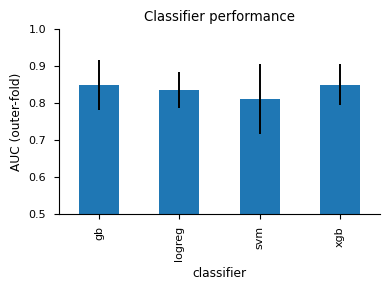

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
auc_means = metrics.pivot(index='fold', columns='classifier', values='auc').mean()
auc_stds  = metrics.pivot(index='fold', columns='classifier', values='auc').std()
auc_means.plot.bar(ax=ax, yerr=auc_stds, capsize=4)
ax.set_ylabel("AUC (outer-fold)")
ax.set_ylim(0.5,1)
ax.set_title("Classifier performance")
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.savefig("fig_auc_bar.png", dpi=600)


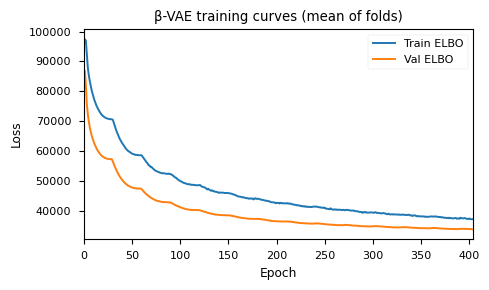

In [10]:
histories = joblib.load(HIST_PATH)
# suponiendo histories = [h_fold1, h_fold2, ..., h_fold5]
min_epochs = min(len(h['train_loss']) for h in histories)

# apila fijo (folds×min_epochs)
train_arr = np.array([h['train_loss'][:min_epochs] for h in histories])
val_arr   = np.array([h['val_loss'][:min_epochs]   for h in histories])

mean_train = train_arr.mean(axis=0)
mean_val   = val_arr.mean(axis=0)

#mean_train = np.nanmean([h['train_loss'] for h in histories], axis=0)
#mean_val   = np.nanmean([h['val_loss']   for h in histories], axis=0)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(mean_train, label='Train ELBO')
ax.plot(mean_val,   label='Val ELBO')
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.legend(); ax.set_title("β-VAE training curves (mean of folds)")
ax.set_xlim(0, len(mean_train))
plt.tight_layout(); plt.savefig("fig_vae_loss.png", dpi=600)


Fold 1 (xgb): AUC = 0.804
Fold 1 (svm): AUC = 0.769
Fold 1 (logreg): AUC = 0.795
Fold 1 (gb): AUC = 0.749
Fold 2 (xgb): AUC = 0.930
Fold 2 (svm): AUC = 0.947
Fold 2 (logreg): AUC = 0.889
Fold 2 (gb): AUC = 0.930
Fold 3 (xgb): AUC = 0.792
Fold 3 (svm): AUC = 0.716
Fold 3 (logreg): AUC = 0.775
Fold 3 (gb): AUC = 0.827
Fold 4 (xgb): AUC = 0.868
Fold 4 (svm): AUC = 0.868
Fold 4 (logreg): AUC = 0.871
Fold 4 (gb): AUC = 0.863
Fold 5 (xgb): AUC = 0.854
Fold 5 (svm): AUC = 0.755
Fold 5 (logreg): AUC = 0.851
Fold 5 (gb): AUC = 0.882

Mejor fold → Fold 2 (svm) con AUC = 0.947


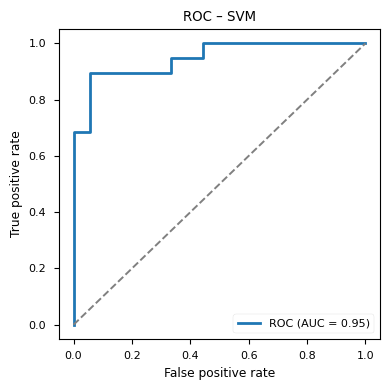

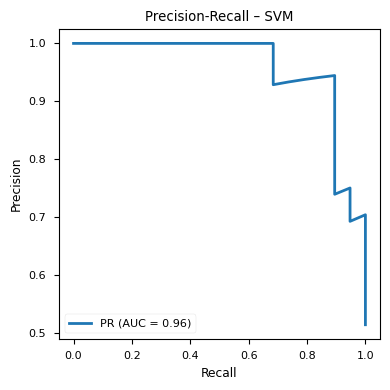

In [13]:
from sklearn.metrics import roc_auc_score

# 1) Calcula la AUC para cada predicción y muéstralas
aucs = []
for d in preds:
    auc_fold = roc_auc_score(d['y_test'], d['proba_test'])
    aucs.append(auc_fold)
    print(f"Fold {d['fold']:d} ({d['classifier']}): AUC = {auc_fold:.3f}")

# 2) Selecciona el mejor diccionario según esa AUC calculada
best_idx = np.argmax(aucs)
best     = preds[best_idx]
best_auc = aucs[best_idx]
print(f"\nMejor fold → Fold {best['fold']} ({best['classifier']}) con AUC = {best_auc:.3f}")

# 3) Genera curvas ROC y PR a partir de ese ‘best’
y_true = best['y_test']
proba  = best['proba_test']

fpr, tpr, _ = roc_curve(y_true, proba)
prec, rec, _ = precision_recall_curve(y_true, proba)
pr_auc = average_precision_score(y_true, proba)

# ROC
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {best_auc:.2f})")
ax.plot([0,1],[0,1],'--', color='grey')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title(f"ROC – {best['classifier'].upper()}")
ax.legend()
plt.tight_layout()
plt.savefig("fig_roc.png", dpi=600)

# PR
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(rec, prec, lw=2, label=f"PR (AUC = {pr_auc:.2f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(f"Precision-Recall – {best['classifier'].upper()}")
ax.legend()
plt.tight_layout()
plt.savefig("fig_pr.png", dpi=600)


In [16]:
# usa los vectores latentes ya serializados por fold_<k>/X_latent_*.npy
latent, labels = [], []
for k in range(1,6):
    path = f"{RESULTS_DIR}/fold_{k}/vae_latent_mu.npy"   # <-- si lo guardaste
    if os.path.exists(path):
        latent.append(np.load(path))
        meta  = pd.read_csv(f"{RESULTS_DIR}/fold_{k}/subjects_meta.csv")  # p.ej.
        labels.append(meta['label'].values)
latent = np.vstack(latent); labels = np.concatenate(labels)
embedding = UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(latent)
palette = {0:"#1f77b4", 1:"#d62728"}           # CN / AD
fig, ax = plt.subplots(figsize=(4,3.8))
for cls in np.unique(labels):
    ix = labels==cls; ax.scatter(embedding[ix,0], embedding[ix,1], 
                                 s=12, alpha=0.7, label="AD" if cls else "CN",
                                 c=palette[cls])
ax.axis('off'); ax.legend(frameon=False)
ax.set_title("Latent UMAP")
plt.tight_layout(); plt.savefig("fig_umap.png", dpi=600)



ValueError: need at least one array to concatenate